In [26]:
%reload_ext autoreload
%autoreload 1
from pprint import pprint
import random
import polars as pl
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from rgf.sklearn import RGFClassifier
import auxiliary.transformers as tr
from auxiliary.transformers import PolarsColumnTransformer as PCT
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import copy
import auxiliary.tuning as tunes
import auxiliary.eda_functions as eda
from ray import tune
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from BorutaShap import BorutaShap
import statistics
from sklearn.utils.validation import check_random_state
%aimport auxiliary.transformers
%aimport auxiliary.tuning
%aimport auxiliary.eda_functions

In [2]:
random.seed(1)

In [3]:
train_data=pl.read_parquet('temp/application_train_filtered.parquet')
id_and_target=['SK_ID_CURR','TARGET']
X_train=train_data.drop(columns=id_and_target)
y_train=train_data['TARGET']

In [4]:
bool_features = []
for feature in X_train.select(pl.col(pl.Utf8)).columns:
    if X_train[feature].n_unique() == 2:
        bool_features.append(feature)

cat_features = [
    feature
    for feature in X_train.select(pl.col(pl.Utf8)).columns
    if feature not in bool_features
]

numeric_features_with_nulls = (
    pl.Series(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES)).columns
    )
    .filter(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES))
        .select(pl.all().is_null().any())
        .transpose()
        .to_series()
    )
    .to_list()
)

In [5]:
preprocessing = Pipeline([])

num_imputer = tr.PolarsColumnTransformer([])
for feature in numeric_features_with_nulls:
    num_imputer.steps[feature] = PCT.Step(
        feature, tr.NumDiffFromRestImputer(), feature
    )
preprocessing.steps.insert(0,('num_imputer', num_imputer))

cat_imputers = tr.PolarsColumnTransformer([])
for feature in cat_features:
    cat_imputers.steps[feature] = PCT.Step(
        feature, tr.NotInImputerPolars(min_values=100, fill_value="other"), feature
    )
preprocessing.steps.append(("cat_imputers", cat_imputers))

encoders = tr.PolarsColumnTransformer([])
for feature in bool_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.PolarsOneHotEncoder(drop=True), feature
    )
for feature in cat_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.TargetMeanOrderedLabeler(how="label"), feature
    )
preprocessing.steps.append(("encoders", encoders))
feature_remover = tr.FeatureRemover([])
preprocessing.steps.append(("feature_removal", feature_remover))

In [6]:
model_lgb=LGBMClassifier(n_jobs=1,verbosity=-1,force_col_wise=True)
sampler_model=tr.SamplingModelWrapper(model_lgb)
full_pipeline=Pipeline([('preprocess', preprocessing),('model',sampler_model)])

In [7]:
preprocessing_etrees=copy.deepcopy(preprocessing)
model_extra_trees = ExtraTreesClassifier(random_state=1,n_jobs=1)
sampler_model_etrees=tr.SamplingModelWrapper(model_extra_trees)
full_pipeline_etrees=Pipeline([('preprocess',preprocessing_etrees),('model',sampler_model_etrees)])


In [8]:
preprocessing_rgf = copy.deepcopy(preprocessing)
model_rgf = RGFClassifier()
sampler_model_rgf=tr.SamplingModelWrapper(model_rgf)
full_pipeline_rgf = Pipeline([("preprocess", preprocessing_rgf), ("model", sampler_model_rgf)])

**Fitting Boruta Shap algorithm on LGBM models with different alpha regularization values**

In [9]:
selector_with_alpha=joblib.load('temp/model_1_selector_alpha1.joblib')
selector_high_alpha=joblib.load('temp/model_1_selector_alpha10.joblib')
selector_no_alpha=joblib.load('temp/model_1_selector_alpha0.joblib')
bad_features_with_alpha=selector_with_alpha.features_to_remove.tolist()
bad_and_tentative_features_alpha=bad_features_with_alpha.copy()
bad_and_tentative_features_alpha.extend(selector_with_alpha.tentative.copy())


bad_features_high_alpha=selector_high_alpha.features_to_remove.tolist()
bad_and_tentative_features_high_alpha=bad_features_high_alpha.copy()
bad_and_tentative_features_high_alpha.extend(selector_high_alpha.tentative.copy())


bad_feature_no_alpha=selector_no_alpha.features_to_remove.tolist()
bad_and_tentative_features_no_alpha=bad_feature_no_alpha.copy()
bad_and_tentative_features_no_alpha.extend(selector_no_alpha.tentative.copy())


In [10]:
feature_quality = {"feature": preprocessing.fit_transform(X_train, y_train).columns}
feature_quality["high_alpha"] = []
feature_quality["alpha"] = []
feature_quality["no_alpha"] = []

for feature in feature_quality["feature"]:
    if feature in bad_features_high_alpha:
        feature_quality["high_alpha"].append("bad")
    elif feature in selector_high_alpha.tentative:
        feature_quality["high_alpha"].append("tentative")
    else:
        feature_quality["high_alpha"].append("good")

for feature in feature_quality["feature"]:
    if feature in bad_features_with_alpha:
        feature_quality["alpha"].append("bad")
    elif feature in selector_with_alpha.tentative:
        feature_quality["alpha"].append("tentative")
    else:
        feature_quality["alpha"].append("good")

for feature in feature_quality["feature"]:
    if feature in bad_features_high_alpha:
        feature_quality["no_alpha"].append("bad")
    elif feature in selector_no_alpha.tentative:
        feature_quality["no_alpha"].append("tentative")
    else:
        feature_quality["no_alpha"].append("good")

feature_quality=pl.DataFrame(feature_quality)


**Features with no consensus**

In [11]:
eda.table_display(feature_quality.filter(
    (pl.col("high_alpha") != pl.col("alpha"))
    | (pl.col("high_alpha") != pl.col("no_alpha"))
    | (pl.col("alpha") != pl.col("no_alpha"))
))


| feature                                   | high_alpha   | alpha     | no_alpha   |
|:------------------------------------------|:-------------|:----------|:-----------|
| AMT_INCOME_TOTAL                          | good         | good      | tentative  |
| DAYS_REGISTRATION                         | tentative    | good      | good       |
| FLAG_WORK_PHONE                           | tentative    | good      | good       |
| LIVINGAREA_MEDI                           | bad          | tentative | bad        |
| DEF_60_CNT_SOCIAL_CIRCLE                  | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_ENDDATE_max            | tentative    | tentative | good       |
| bureau_AMT_CREDIT_MAX_OVERDUE_max         | tentative    | tentative | good       |
| bureau_AMT_CREDIT_SUM_mean                | tentative    | good      | good       |
| bureau_AMT_CREDIT_SUM_max                 | tentative    | tentative | good       |
| bureau_AMT_CREDIT_SUM_LIMIT_mean          | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_mean                   | tentative    | good      | good       |
| bureau_DAYS_CREDIT_sum                    | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_UPDATE_std             | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_ENDDATE_mean_Active    | tentative    | good      | good       |
| bureau_DAYS_CREDIT_ENDDATE_mode_Active    | bad          | tentative | bad        |
| bureau_AMT_CREDIT_MAX_OVERDUE_mean_Active | bad          | tentative | bad        |
| bureau_AMT_CREDIT_SUM_mean_Active         | bad          | tentative | bad        |
| bureau_AMT_CREDIT_SUM_DEBT_sum_Active     | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_mean_Active            | bad          | tentative | bad        |
| prev_AMT_CREDIT_mean_Approved             | bad          | tentative | bad        |
| prev_AMT_CREDIT_sum_Revolving_loans       | tentative    | tentative | good       |
| NAME_INCOME_TYPE                          | tentative    | good      | good       |
| NAME_HOUSING_TYPE                         | bad          | tentative | bad        |
| WALLSMATERIAL_MODE                        | bad          | tentative | bad        |
| NAME_CONTRACT_TYPE_Cash loans             | tentative    | good      | good       |

In [12]:
feature_quality = feature_quality.with_columns(
    feature_quality.map_rows(lambda x: statistics.mode(x[1:]))
    .to_series()
    .alias("consensus")
)

In [13]:
consensus_bad_tentative_features=feature_quality.filter(pl.col("consensus")!="good")['feature'].to_list()
consensus_bad_features=feature_quality.filter(pl.col("consensus")=="bad")['feature'].to_list()
feature_removal_list=[consensus_bad_features,consensus_bad_tentative_features]

In [14]:
models = tunes.Models()
model_params_lgb = {
    "max_depth": tune.randint(5, 30),
    "num_leaves": tune.randint(10, 1000),
    "n_estimators": tune.randint(10, 251),
    "learning_rate": tune.loguniform(0.001, 0.1),
    "bagging_freq": tune.randint(0, 11),
    "colsample_bytree": tune.uniform(0.2, 1.0),
    "subsample": tune.uniform(0.2, 1.0),
    "reg_alpha": tune.loguniform(0.001, 100),
    "reg_lambda": tune.loguniform(0.001, 100),
    "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "class_weight": tune.choice(["balanced", None]),
    "max_bin": tune.randint(5, 201),
}

search_space_lgbm = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_lgb,
    "model__sampler": tune.choice(['smote','adasyn','random',None])
}

models.add_model(
    "lgbm", full_pipeline, search_space_lgbm, metric_threshold=0.77
)


In [15]:
model_params_extra_trees = {
    "n_estimators": tune.randint(10, 251),
    "max_depth": tune.randint(5, 30),
    "max_leaf_nodes": tune.randint(30,1000),
    "min_samples_split": tune.randint(2, 21),
    "min_samples_leaf": tune.randint(1, 21),
    "max_features": tune.uniform(0.1,1.0),
    "class_weight": tune.choice(["balanced","balanced_subsample" , None]),
    "max_samples": tune.uniform(0.1, 1.0),
}

search_space_extra_trees = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_extra_trees,
    "model__sampler": tune.choice(['smote', 'adasyn', 'random', None])
}

models.add_model(
    "extra_trees", full_pipeline_etrees, search_space_extra_trees, metric_threshold=0.73
)


In [16]:
model_params_rgf = {
    "algorithm": tune.choice(["RGF", "RGF Opt", "RGF Sib"]),
    "loss": tune.choice(["LS", "Expo", "Log", "Abs"]),
    "l2": tune.loguniform(1e-6, 1.0),
    "max_leaf": tune.randint(10, 1000),
    "test_interval": tune.quniform(100,1000,100),
    "reg_depth": tune.randint(1, 21),
    "learning_rate": tune.loguniform(1e-6, 1.0),
}

search_space_rgf = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_rgf,
    "model__sampler": tune.choice(['smote', 'adasyn', 'random', None])
}

models.add_model(
    "rgf", full_pipeline_rgf, search_space_rgf, metric_threshold=0.76
)


In [17]:
models=joblib.load("temp/model_1_tuned_models.joblib")

In [18]:
for model in models.models.values():
    print(model.name)
    print("----------------")
    for key,param in model.best_params.items():
        if key[:3]=="mod":
            pprint(key+":")
            pprint(param)
            print("")


lgbm
----------------
'model__model_params:'
{'bagging_freq': 4,
 'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8014252957700048,
 'learning_rate': 0.024615541208760996,
 'max_bin': 195,
 'max_depth': 11,
 'n_estimators': 130,
 'num_leaves': 850,
 'reg_alpha': 0.1867708640086517,
 'reg_lambda': 0.05040568844637988,
 'subsample': 0.3674293085589498}

'model__sampler:'
'random'

extra_trees
----------------
'model__model_params:'
{'class_weight': 'balanced_subsample',
 'max_depth': 17,
 'max_features': 0.6415290560036582,
 'max_leaf_nodes': 184,
 'max_samples': 0.4259865167145781,
 'min_samples_leaf': 4,
 'min_samples_split': 18,
 'n_estimators': 222}

'model__sampler:'
None

rgf
----------------
'model__model_params:'
{'algorithm': 'RGF Opt',
 'l2': 0.0017590322410677072,
 'learning_rate': 0.00023978850531378984,
 'loss': 'Log',
 'max_leaf': 908,
 'reg_depth': 1,
 'test_interval': 700.0}

'model__sampler:'
'random'



In [23]:
scores={}
for model in models.models.values():
    scores[model.name]=np.array(model.cross_val_roc_auc(X_train,y_train))
    print(model.name)
    print(scores[model.name].mean())
scores=pl.DataFrame(scores)

lgbm
0.7728888468935435
extra_trees
0.7325794744698934
rgf
0.7750529599284133


In [28]:
scores

lgbm,extra_trees,rgf
f64,f64,f64
0.772106,0.7342,0.773761
0.774733,0.735193,0.776159
0.76761,0.724074,0.770123
0.774824,0.735596,0.777819
0.775171,0.733834,0.777402


[Text(0, 0, 'lgbm'), Text(1, 0, 'extra_trees'), Text(2, 0, 'rgf')]

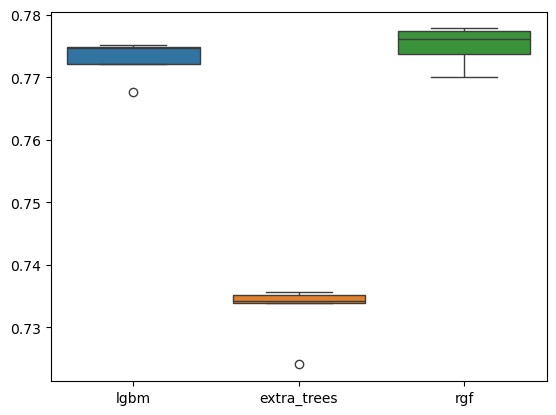

In [31]:
fig_scores,ax_scores=plt.subplots()
sns.boxplot(scores)
ax_scores.set_xticklabels(scores.columns)

In [33]:
from sklearn.ensemble import StackingClassifier
final_estimator=LGBMClassifier(random_state=1,n_jobs=1)
model_stack=StackingClassifier([model.pipeline for model in models.models.values()],final_estimator=final_estimator)

In [34]:
from sklearn.model_selection import cross_val_score
final_score=cross_val_score(model_stack,X_train,y_train)

AttributeError: 'str' object has no attribute 'name'

In [42]:
from mlflow import MlflowClient
import mlflow

In [35]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [38]:
all_experiments = client.search_experiments()

pprint(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1699608362110, experiment_id='0', last_update_time=1699608362110, lifecycle_stage='active', name='Default', tags={}>]


In [40]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the grocery forecasting project. "
    "This experiment contains the produce models for apples."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "grocery-forecasting",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="Apple_Models", tags=experiment_tags
)


In [39]:
default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]

pprint(default_experiment)

{'lifecycle_stage': 'active', 'name': 'Default'}


In [43]:

mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [44]:
apple_experiment = mlflow.set_experiment("Default")

In [48]:
models.models['lgbm'].pipeline.fit(X_train,y_train)

# Predict on the validation set
y_pred = models.models['lgbm'].pipeline.predict_proba(X_train)[:,1]

# Calculate error metrics
roc_auc=roc_auc_score(y_train,y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"roc_auc": roc_auc}

# Initiate the MLflow run context
with mlflow.start_run(run_name="run1") as run:
    # Log the parameters used for the model fit
    mlflow.log_params(models.models['lgbm'].best_params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=models.models['lgbm'].pipeline, artifact_path="exp_2"
    )


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('num_imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('AMT_ANNUITY',
                                                                              <auxiliary.transformers.PolarsColumnTransformer.Step object at 0x7f1a69791a60>),
                                                                             ('AMT_GOODS_PRICE',
                                                                              <auxiliary.transformers.PolarsColumnTransformer.Step object at 0x7f1a697ab9d0>),
                                                                             ('OWN_CAR_AGE',
                                                                              <auxiliary.transformers.PolarsColumnTransfo...
                                                           n_jobs=1,
                                                           verbosity=-1),
                                      model_params={'bagging_freq': 4,
                                                    'boosting_type': 'gbdt',
                                                    'class_weight': None,
                                                    'colsample_bytree': 0.8014252957700048,
                                                    'learning_rate': 0.024615541208760996,
                                                    'max_bin': 195,
                                                    'max_depth': 11,
                                                    'n_estimators': 130,
                                                    'num_leaves': 850,
                                                    'reg_alpha': 0.1867708640086517,
                                                    'reg_lambda': 0.05040568844637988,
                                                    'subsample': 0.3674293085589498},
                                      sampler='random'))])

In [21]:
models.models['lgbm'].pipeline['model'].model.feature_importances_

array([ 33, 157, 103,  92,  31, 139,  91,  45,  74,  60,  11,  29, 170,
       158, 147,  22,  48,  14,  19,  35,  37,  38,  41,  17,  20,  10,
        36,  29,  47,  45,  33,  28,  31,  20,  16,  28,  31,  41,  40,
        20,  26,  51,  24,  36,  66,  31,  23,  28,  93,  13,  29,  25,
       113,  41,  56,  40,  13,  36,  28,  35,  15,  68,  24], dtype=int32)

In [22]:
cols=models.models['lgbm'].pipeline['preprocess'].fit_transform(X_train,y_train).columns

In [23]:
feats=pl.DataFrame({'imp':models.models['lgbm'].pipeline['model'].model.feature_importances_,'feat':cols})
feats.sort('imp')[-6,1]

'prev_payment_left'

In [25]:
eda.table_display(feats.sort("imp"))

|   imp | feat                                     |
|------:|:-----------------------------------------|
|    10 | bureau_AMT_CREDIT_MAX_OVERDUE_max        |
|    11 | FLAG_WORK_PHONE                          |
|    13 | prev_AMT_CREDIT_sum_Revolving_loans      |
|    13 | NAME_INCOME_TYPE                         |
|    14 | FLAG_DOCUMENT_3                          |
|    15 | WEEKDAY_APPR_PROCESS_START               |
|    16 | bureau_DAYS_CREDIT_ENDDATE_sum_Active    |
|    17 | bureau_AMT_CREDIT_MAX_OVERDUE_mean       |
|    19 | AMT_REQ_CREDIT_BUREAU_QRT                |
|    20 | bureau_AMT_CREDIT_MAX_OVERDUE_sum        |
|    20 | bureau_DAYS_CREDIT_ENDDATE_mean_Active   |
|    20 | bureau_AMT_CREDIT_SUM_DEBT_mean_Active   |
|    22 | DEF_30_CNT_SOCIAL_CIRCLE                 |
|    23 | prev_AMT_CREDIT_sum_Refused              |
|    24 | bureau_DAYS_CREDIT_mode_Active           |
|    24 | NAME_CONTRACT_TYPE_Cash loans            |
|    25 | prev_count_Refused                       |
|    26 | bureau_AMT_CREDIT_SUM_DEBT_min_Active    |
|    28 | bureau_DAYS_CREDIT_max                   |
|    28 | bureau_DAYS_CREDIT_ENDDATE_min_Active    |
|    28 | prev_AMT_CREDIT_mean_Consumer_loans      |
|    28 | NAME_FAMILY_STATUS                       |
|    29 | REGION_RATING_CLIENT_W_CITY              |
|    29 | bureau_AMT_CREDIT_SUM_sum                |
|    29 | prev_count_Approved                      |
|    31 | REGION_POPULATION_RELATIVE               |
|    31 | bureau_DAYS_CREDIT_mode                  |
|    31 | bureau_DAYS_CREDIT_ENDDATE_max_Active    |
|    31 | prev_AMT_CREDIT_mean_Refused             |
|    33 | AMT_INCOME_TOTAL                         |
|    33 | bureau_DAYS_CREDIT_mean                  |
|    35 | bureau_DAYS_CREDIT_ENDDATE_max           |
|    35 | OCCUPATION_TYPE                          |
|    36 | bureau_AMT_CREDIT_SUM_mean               |
|    36 | bureau_count_Active                      |
|    36 | NAME_EDUCATION_TYPE                      |
|    37 | bureau_DAYS_CREDIT_ENDDATE_mode          |
|    38 | bureau_DAYS_ENDDATE_FACT_max             |
|    40 | bureau_AMT_CREDIT_SUM_min_Active         |
|    40 | CODE_GENDER                              |
|    41 | bureau_DAYS_ENDDATE_FACT_std             |
|    41 | bureau_AMT_CREDIT_MAX_OVERDUE_sum_Active |
|    41 | prev_AMT_BALANCE_CURR_sum                |
|    45 | DAYS_REGISTRATION                        |
|    45 | bureau_AMT_CREDIT_SUM_DEBT_mean          |
|    47 | bureau_AMT_CREDIT_SUM_max                |
|    48 | DAYS_LAST_PHONE_CHANGE                   |
|    51 | bureau_DAYS_CREDIT_max_Active            |
|    56 | prev_curr_bal_lim_diff_sum               |
|    60 | OWN_CAR_AGE                              |
|    66 | prev_AMT_CREDIT_sum_Approved             |
|    68 | ORGANIZATION_TYPE                        |
|    74 | DAYS_ID_PUBLISH                          |
|    91 | DAYS_EMPLOYED                            |
|    92 | AMT_GOODS_PRICE                          |
|    93 | prev_AMT_CREDIT_sum_Consumer_loans       |
|   103 | AMT_ANNUITY                              |
|   113 | prev_payment_left                        |
|   139 | DAYS_BIRTH                               |
|   147 | EXT_SOURCE_3                             |
|   157 | AMT_CREDIT                               |
|   158 | EXT_SOURCE_2                             |
|   170 | EXT_SOURCE_1                             |

In [27]:
scores = []
for train_index, test_index in StratifiedKFold(5).split(X_train, y_train):
    models.models["lgbm"].pipeline.fit(
        X_train[train_index], y_train[train_index]
    )
    scores.append(
        roc_auc_score(
            y_train[test_index],
            models.models["lgbm"].pipeline.predict_proba(
                X_train[test_index]
            )[:,1],
        )
    )